In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# #torch.cuda.empty_cache()
# # memory footprint support libraries/code
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil
# !pip install psutil
# !pip install humanize
# import psutil
# import humanize
# import os
# import GPUtil as GPU
# GPUs = GPU.getGPUs()
# # XXX: only one GPU on Colab and isn’t guaranteed
# gpu = GPUs[0]
# def printm():
#  process = psutil.Process(os.getpid())
#  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
#  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
# printm() 

In [6]:
# import pandas_datareader
# from pandas_datareader import data, wb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [39]:
import logging
import os
import time
import sys

import torch
import torch.nn as nn
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.utils import data
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from torch.utils.data import DataLoader,Dataset, TensorDataset

In [8]:
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot
from scipy import stats as ss

In [10]:
data = pd.read_csv(os.path.join('/content/drive/My Drive/3001TS/citibike_1520.csv'))
data.head()

,Unnamed: 0,starttime_day,usertype,tripduration,tripdistance
0,0,2015-01-01,5317,801.806658,0.880446
1,1,2015-01-02,11304,731.240977,0.929326
2,2,2015-01-03,4478,655.284279,0.860687
3,3,2015-01-04,7849,679.554211,0.896166
4,4,2015-01-05,14506,637.811802,0.938065


In [11]:
#data = data.drop(columns='Unnamed: 0')
data= data.rename(columns={'usertype':'daily_counts'})
data['starttime_day'] = pd.to_datetime(data['starttime_day'])

In [12]:
data

,Unnamed: 0,starttime_day,daily_counts,tripduration,tripdistance
0,0,2015-01-01,5317,801.806658,0.880446
1,1,2015-01-02,11304,731.240977,0.929326
2,2,2015-01-03,4478,655.284279,0.860687
3,3,2015-01-04,7849,679.554211,0.896166
4,4,2015-01-05,14506,637.811802,0.938065
...,...,...,...,...,...
2118,26,2020-10-27,78030,969.498424,1.266052
2119,27,2020-10-28,62847,993.646172,1.244965
2120,28,2020-10-29,19072,861.612154,1.117977
2121,29,2020-10-30,39546,910.687023,1.123494


### Get summary

In [13]:
def getDfSummary(input_data):
    # Turn input into a dataframe
    data = pd.DataFrame(data=input_data)
    
    # Create a new data frame for the results
    index_names = list(input_data.columns)
    col_names = ['number_nan','percent_missing','number_distinct','mean','max','min','std','25%','50%','75%']
    df_summary = pd.DataFrame(columns = col_names,index = index_names)
        
    # Count the missing not-a-number values
    df_summary['number_nan'] = list(input_data.isna().sum())
    df_summary['percent_missing'] = list(input_data.isna().sum()/input_data.shape[0])
    
    # Count the number of distinct values for each variable
    df_summary['number_distinct'] = list(input_data.nunique())
    
    # Output the summary information of the input data
    data_describe = input_data.describe()
    summary_features = ['mean','max','min','std','25%','50%','75%']
    for i in summary_features:
        df_summary[i] = data_describe.loc[i]
    # Return the results  
    return df_summary

getDfSummary(data)

,number_nan,percent_missing,number_distinct,mean,max,min,std,25%,50%,75%
Unnamed: 0,0,0.0,31,14.680170,30.000000,0.000000,8.778826,7.000000,15.000000,22.000000
starttime_day,0,0.0,2123,NaN,NaN,NaN,NaN,NaN,NaN,NaN
daily_counts,0,0.0,2099,44690.419689,101462.000000,1107.000000,21284.594697,28541.000000,42738.000000,61085.000000
tripduration,0,0.0,2123,999.375561,2158.759199,569.858582,262.555638,812.762821,937.247620,1136.795286
tripdistance,0,0.0,2123,1.110741,3.684443,0.737004,0.149159,1.024329,1.101891,1.173625


### Train val test split

In [14]:
pre = data[data['starttime_day'] < '2020-03-01']
post = data[data['starttime_day'] >= '2020-03-01']

In [15]:
pre_train = pre.iloc[:-375,:]
pre_val = pre.iloc[-375:,:]

### Standardize data

In [16]:
from sklearn.preprocessing import StandardScaler
prescaler = StandardScaler()

In [17]:
prescaler.fit(np.array(pre_train['daily_counts']).reshape(-1,1))
pre_train['daily_counts_std'] = prescaler.transform(np.array(pre_train['daily_counts']).reshape(-1,1))
pre_val['daily_counts_std'] = prescaler.transform(np.array(pre_val['daily_counts']).reshape(-1,1))

### Dickey Fuller Test

P-value is 0.06 (>=0.05) so we cannot reject the null hypothesis and cannot conclude that the data is stationary.

In [18]:
#Define a function that performs Dickey-Fuller test and plot the moving average/moving std:

def DF_test(data, datecol='starttime_day', values='daily_counts_std'):
    dftest = adfuller(data[values], autolag = 'AIC')

    dfoutput = pd.Series(dftest[0:4],index = ['Test Statistic','p-value','#Lags Used', 'Num of obs'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' %key] = value
    print('Results of Dickey-Fuller test:')    
    print(dfoutput)

    plt.figure(figsize=(20,10))

    ig, ax = plt.subplots(figsize=(20, 5))
    org = ax.plot(data[datecol], data[values])

    plt.title('Citibike Daily Data (2015-2020)')
    plt.legend(loc= 'best')
    plt.show(block=False)

No handles with labels found to put in legend.


Results of Dickey-Fuller test:
Test Statistic            -2.503489
p-value                    0.114628
#Lags Used                22.000000
Num of obs              1480.000000
Critical Value (1%)       -3.434776
Critical Value (5%)       -2.863495
Critical Value (10%)      -2.567811
dtype: float64


<Figure size 1440x720 with 0 Axes>

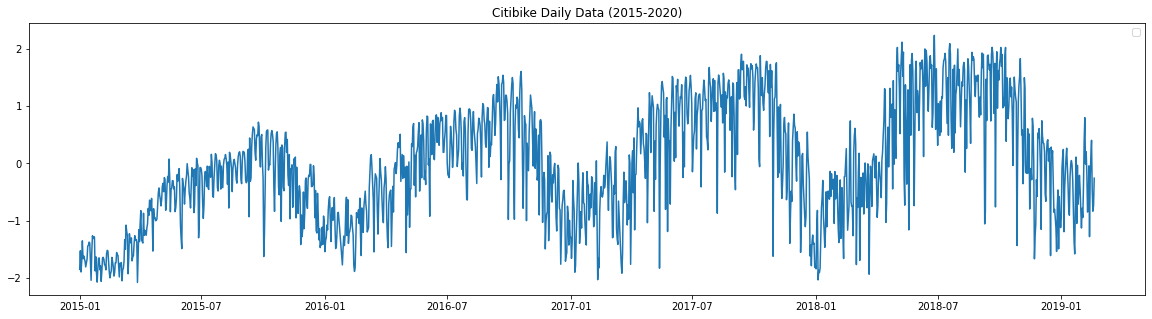

In [19]:
DF_test(pre_train)

### Plot ACF, PACF

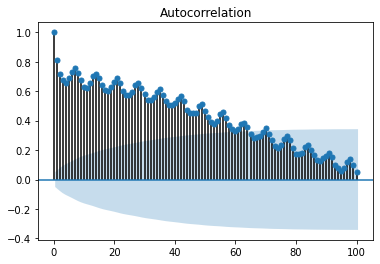

In [20]:
plot_acf(x=pre_train['daily_counts_std'], lags=100)
plt.show()

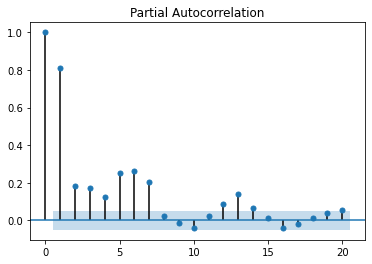

In [21]:
plot_pacf(x=pre_train['daily_counts_std'], lags=20)
plt.show()

### RNN/ LSTM

#### Data prep - sliding window
Ref: https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/

In [40]:
train_window = 22 #base on number of lags from Dickey Fuller Test
def create_sequence_data(input_data, window, output_size=1):
    sequences = []
    labels = []
    length = len(input_data)
    for i in range(length - window - output_size):
        seq = input_data[i:i+window]
        label = input_data[i+tw:i+tw+output_size]
        sequences.append(seq)
        labels.append(label)
    return TensorDataset(sequences, labels)

In [47]:
def _get_data_loader(sequence_data, batch_size=16, window=train_window,shuffle=False,output_size=1):
  data_loader = DataLoader(sequence_data, batch_size=batch_size,shuffle=shuffle,drop_last=True)
  return data_loader

In [43]:
train_data_normalized = np.array(pre_train['daily_counts_std'])
val_data_normalized = np.array(pre_val['daily_counts_std'])

In [44]:
train_sequence = create_inout_sequences(train_data_normalized, train_window)
val_sequence = create_inout_sequences(val_data_normalized, train_window)

In [46]:
train_sequence[1],val_sequence[1]

((array([-1.52683342, -1.89748648, -1.71444055, -1.35296422, -1.66611339,
         -1.61686312, -1.66394138, -1.71004224, -1.80892288, -1.73518323,
         -1.67121761, -1.44576324, -1.43007049, -1.3763676 , -1.38896525,
         -1.73388002, -2.04317388, -1.55908773, -1.26483502, -1.31343369,
         -1.27922457, -1.28612069]), array([-1.87924162])),
 (array([ 0.0041603 ,  0.12877923, -0.42432246, -0.82266861, -0.28270757,
         -0.10351696, -0.16004346, -0.06512673, -0.49898521, -1.16318508,
         -0.87876071, -0.59737715, -0.12626874, -0.33358685, -0.19088596,
          0.05341057, -0.0268451 , -1.11453211,  0.7053929 ,  0.42270613,
          0.58088257,  0.97977173]), array([0.98194374])))

In [48]:
train_loader = _get_data_loader(train_sequence)
val_loader = _get_data_loader(val_sequence)

In [52]:
len(train_loader)

92

In [89]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, batch_size=16, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size,batch_first=True)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.batch_size = batch_size

    def forward(self, input_seq):
        #weight = next(self.parameters()).data
        hidden_cell = (torch.zeros(1,self.batch_size,self.hidden_layer_size),
                            torch.zeros(1,self.batch_size,self.hidden_layer_size))
        print(input_seq.shape)
        input_seq = input_seq.view(len(input_seq),1, -1)
        print(input_seq.shape)
        lstm_out, _ = self.lstm(input_seq, hidden_cell)
        print(lstm_out.shape)
        lstm_out = lstm_out.view(len(input_seq), -1)
        print(lstm_out.shape)
        predictions = self.linear(lstm_out)
        print(predictions.shape, predictions[-1].shape)
        return predictions[-1]


In [90]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [91]:
print(model)

LSTM(
  (lstm): LSTM(1, 100, batch_first=True)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [93]:
seq, labels = next(iter(train_loader))
print(seq.shape, seq.view(len(seq) ,1, -1).shape)
y = model(seq)

torch.Size([16, 22]) torch.Size([16, 1, 22])
torch.Size([16, 22])
torch.Size([16, 1, 22])


RuntimeError: ignored

In [94]:
epochs = 150
def train(epochs, train_loader):
  model.train()
  for i in range(epochs):
      mean_loss = 0
      for i, (seq, labels) in enumerate(train_loader) :
          seq, labels = seq.to(device), labels.to(device)
          optimizer.zero_grad()
          model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                          torch.zeros(1, 1, model.hidden_layer_size))
          print(seq.shape)
          y_pred = model(seq)

          loss = loss_function(y_pred, labels)
          mean_loss += loss.item()
          loss.backward()
          optimizer.step()

      mean_loss /= len(train_loader)

      # if i%25 == 1:
      #     print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

  print(f'epoch: {i} | loss: {mean_loss:10.10f}')